Reference:
/***************************************************************************************
*    Title: Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks
*    Author: Ray William
*    Date: 16 Feb 2021
*    Code version: 1.0
*    Availability: https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
*
*    Title: The Correct Way to Measure Inference Time of Deep Neural Networks
*    Author: Amnon Geifman
*    Date: 1 May 2023
*    Code version: 1.0
*    Availability: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
*
*    ##dataset
*    Title: UtkMl's Twitter Spam Detection Competition
*    Author: UtkMl
*    Date: 27 Mar 2019
*    Code version: 1.0
*    Availability: https://www.kaggle.com/competitions/twitter-spam/overview
*
***************************************************************************************/

In [ ]:
!pip install transformers

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install -U tensorboard_plugin_profile

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sys
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer, AutoConfig

In [ ]:
from transformers import TFAutoModelForSequenceClassification, TFAlbertModel, AlbertTokenizerFast, AlbertConfig

In [ ]:
train_data = pd.read_csv('/content/gdrive/My Drive/dataset/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/dataset/test.csv')

In [ ]:
train_data.head()

In [ ]:
train_data.drop(['Id','following','followers','actions','is_retweet','location'], axis=1, inplace=True)
train_data['Type'] = train_data['Type'].replace({'Quality':0, 'Spam':1})

In [ ]:
train_data.head()

In [ ]:
train_data_shuffled = train_data.sample(frac=1)
train_data_shuffled.reset_index(inplace=True, drop=True)

In [ ]:
train_data_shuffled.head()

In [ ]:
train_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11968 non-null  object
 1   Type    11968 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.1+ KB


In [ ]:
print(
    "Total number of Spam and non-Spam tweets: "
    f"{train_data_shuffled.Type.value_counts()}"
      )

Total number of Spam and non-Spam tweets: 0    6153
1    5815
Name: Type, dtype: int64


In [ ]:
for index, example in train_data_shuffled[:5].iterrows():
    print(f"Example #{index}")
    print(f"\tType : {example['Type']}")
    print(f"\tTweet : {example['Tweet']}")

Example #0
	Type : 0
	Tweet : JIMIN DO U WANT ME DEADpic.twitter.com/uTII0NxhYN
Example #1
	Type : 1
	Tweet : #emmss Celebrities Blame Trump for the Charlottesville Attack https://t.co/VafcYrKi9c #emms https://t.co/uq3YO0MJpP
Example #2
	Type : 1
	Tweet : 'Barrel Chested Bandit' apprehended in Arizona, FBI said https://t.co/URowIf73Ai https://t.co/44IHFkNk3A
Example #3
	Type : 1
	Tweet : John Glenn lived his life serving the nation he love &amp; defined what it means to be an American hero. RIP. https://t.co/Gv499sowit https://t.co/eH7w7r9OaQ
Example #4
	Type : 0
	Tweet : Dong Youngbae. As bright as the sun  Always shinniiing!!
Happy Birthday Baeby 
#HAPPYBAEBAEDAY 
.pic.twitter.com/z4Hacm7Ds3


In [ ]:
test_df = train_data_shuffled.sample(frac=0.1)
train_df = train_data_shuffled.drop(test_df.index)
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index)
print(f"Using {len(train_df)} samples for training and {len(valid_df)} for validation and {len(test_df)} for testing")
print(train_df["Type"].value_counts())
print(valid_df["Type"].value_counts())
print(test_df["Type"].value_counts())

Using 8617 samples for training and 2154 for validation and 1197 for testing
0    4440
1    4177
Name: Type, dtype: int64
0    1092
1    1062
Name: Type, dtype: int64
0    621
1    576
Name: Type, dtype: int64


In [ ]:
X_train_df = train_df[['Tweet']]
Y_train_df = train_df[['Type']]
X_valid_df = valid_df[['Tweet']]
Y_valid_df = valid_df[['Type']]
X_test_df = test_df[['Tweet']]
Y_test_df = test_df[['Type']]

In [ ]:
print(X_train_df)
print(Y_train_df)
print(X_valid_df)
print(Y_valid_df)
print(X_test_df)
print(Y_test_df)

In [ ]:
MAX_LENGTH = 128
TF_DROPOUT = 0.25
TF_ATT_DROPOUT = 0.2
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
EPOCHS = 6
BATCH_SIZE = 64
FT_EPOCHS = 5

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):

    input_ids_list = []
    attention_mask_list = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids_list.extend(inputs['input_ids'])
        attention_mask_list.extend(inputs['attention_mask'])


    return {
        'input_ids': tf.convert_to_tensor(input_ids_list),
        'attention_mask':tf.convert_to_tensor(attention_mask_list)
    }


X_train_encoded = batch_encode(tokenizer, X_train_df['Tweet'].tolist())

X_valid_encoded = batch_encode(tokenizer, X_valid_df['Tweet'].tolist())

X_test_encoded = batch_encode(tokenizer, X_test_df['Tweet'].tolist())

In [ ]:
print(X_train_encoded)

{'input_ids': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[    2,   547,    45, ...,     0,     0,     0],
       [    2,    31,  1376, ...,     0,     0,     0],
       [    2,  6926,   804, ...,     0,     0,     0],
       ...,
       [    2,  6926,  3904, ...,     0,     0,     0],
       [    2,   483, 21217, ...,     0,     0,     0],
       [    2,   636, 13405, ..., 12851,   263,     3]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}


In [ ]:
config = AlbertConfig.from_pretrained('albert-base-v2',
                                      dropout=TF_DROPOUT,
                                      attention_dropout=TF_ATT_DROPOUT,
                                      output_hidden_states=True)

TFModel = TFAlbertModel.from_pretrained('albert-base-v2', config=config)

for layer in TFModel.layers:
    layer.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name='input_attention',
                                                  dtype='int32')

    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]

    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(tf.keras.layers.Reshape((1, -1))(cls_token))
    bi_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(bi_lstm)
    bi_lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(bi_lstm2)

    flat_bi_lstm = tf.keras.layers.Flatten()(bi_lstm3)

    dropout = tf.keras.layers.Dropout(rate=TF_DROPOUT)(flat_bi_lstm)

    dense = tf.keras.layers.Dense(units=128, activation='relu')(dropout)

    output = tf.keras.layers.Dense(1,
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(dense)

    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss="binary_crossentropy",
                  metrics=["Accuracy", "Recall", "Precision", "AUC"])

    return model

In [ ]:
model = build_model(TFModel)

In [ ]:
NUM_STEPS = len(X_train_df.index) // BATCH_SIZE

In [ ]:
print(NUM_STEPS)

134


In [ ]:
from datetime import datetime

In [ ]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode = 'min', restore_best_weights=True)

In [ ]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 update_freq = 'epoch')

In [ ]:
tf.profiler.experimental.start('logs/')
start2 = tf.timestamp()
train_history1 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end2 = tf.timestamp()
tf.profiler.experimental.stop()
timings2 = end2 - start2
print(timings2)

Epoch 1/6
134/134 - 62s - loss: 0.5961 - Accuracy: 0.7418 - recall: 0.6862 - precision: 0.7580 - auc: 0.7913 - val_loss: 0.4389 - val_Accuracy: 0.7920 - val_recall: 0.7599 - val_precision: 0.8070 - val_auc: 0.8834 - 62s/epoch - 466ms/step
Epoch 2/6
134/134 - 33s - loss: 0.3630 - Accuracy: 0.8429 - recall: 0.8271 - precision: 0.8451 - auc: 0.9207 - val_loss: 0.3178 - val_Accuracy: 0.8705 - val_recall: 0.8343 - val_precision: 0.8959 - val_auc: 0.9410 - 33s/epoch - 249ms/step
Epoch 3/6
134/134 - 33s - loss: 0.2876 - Accuracy: 0.8788 - recall: 0.8791 - precision: 0.8726 - auc: 0.9500 - val_loss: 0.2817 - val_Accuracy: 0.8872 - val_recall: 0.8945 - val_precision: 0.8788 - val_auc: 0.9516 - 33s/epoch - 249ms/step
Epoch 4/6
134/134 - 33s - loss: 0.2441 - Accuracy: 0.9023 - recall: 0.9012 - precision: 0.8973 - auc: 0.9639 - val_loss: 0.2534 - val_Accuracy: 0.8923 - val_recall: 0.9021 - val_precision: 0.8821 - val_auc: 0.9611 - 33s/epoch - 249ms/step
Epoch 5/6
134/134 - 33s - loss: 0.2221 - Acc

In [ ]:
model.summary()

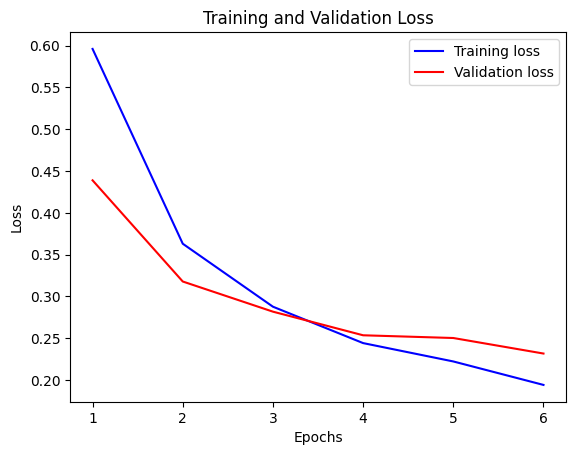

In [ ]:
training_loss = train_history1.history['loss']
validation_loss = train_history1.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for layer in TFModel.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss="binary_crossentropy",
              metrics=["Accuracy", "Recall", "Precision", "AUC"])

tf.profiler.experimental.start('logs/')
start3 = tf.timestamp()
train_history2 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end3 = tf.timestamp()
tf.profiler.experimental.stop()
timings3= end3 - start3
print(timings3)

Epoch 1/5


134/134 - 106s - loss: 0.1306 - Accuracy: 0.9521 - recall: 0.9466 - precision: 0.9542 - auc: 0.9896 - val_loss: 0.1072 - val_Accuracy: 0.9587 - val_recall: 0.9595 - val_precision: 0.9568 - val_auc: 0.9929 - 106s/epoch - 789ms/step
Epoch 2/5
134/134 - 75s - loss: 0.0589 - Accuracy: 0.9792 - recall: 0.9769 - precision: 0.9802 - auc: 0.9978 - val_loss: 0.1031 - val_Accuracy: 0.9670 - val_recall: 0.9614 - val_precision: 0.9715 - val_auc: 0.9933 - 75s/epoch - 556ms/step
Epoch 3/5
Restoring model weights from the end of the best epoch: 2.
134/134 - 75s - loss: 0.0321 - Accuracy: 0.9891 - recall: 0.9860 - precision: 0.9915 - auc: 0.9993 - val_loss: 0.1121 - val_Accuracy: 0.9647 - val_recall: 0.9520 - val_precision: 0.9759 - val_auc: 0.9916 - 75s/epoch - 557ms/step
Epoch 3: early stopping
tf.Tensor(255.00988698005676, shape=(), dtype=float64)


In [ ]:
model.summary()

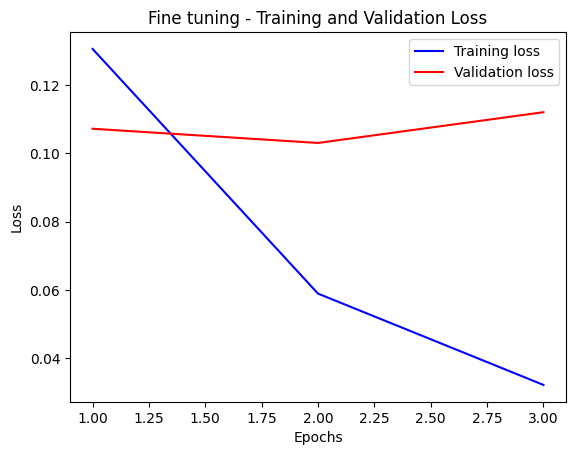

In [ ]:
training_loss2 = train_history2.history['loss']
validation_loss2 = train_history2.history['val_loss']

epochs = range(1, len(training_loss2) + 1)
plt.plot(epochs, training_loss2, 'b', label='Training loss')
plt.plot(epochs, validation_loss2, 'r', label='Validation loss')
plt.title('Fine tuning - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
y_pred = model.predict([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], batch_size=128, verbose=1)
y_pred_class = (y_pred > 0.5).astype(int)
target_names = ['Ham','Spam']

print(classification_report(Y_test_df, y_pred_class,target_names=target_names,digits=4 ))

10/10 [==============================] - 8s 315ms/step
              precision    recall  f1-score   support

         Ham     0.9790    0.9742    0.9766       621
        Spam     0.9724    0.9774    0.9749       576

    accuracy                         0.9758      1197
   macro avg     0.9757    0.9758    0.9757      1197
weighted avg     0.9758    0.9758    0.9758      1197



In [ ]:
print(y_pred_class)

In [ ]:
print(y_pred)

In [ ]:
print('spam' if y_pred [0][0] > 0.5 else 'not spam')

not spam


In [ ]:
model.save('/content/gdrive/My Drive/model/Albert3/',overwrite=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
testmodel = tf.saved_model.load('/content/gdrive/My Drive/model/Albert3/')

In [ ]:
tf.profiler.experimental.stop()

In [ ]:
testtokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
dummyinput = 'Obama Criminal Enterprise Collapsing  https://t.co/zIWjkQNMkh https://t.co/3gkxKiCqgP #TCOT #MAGA #PJNET https://t.co/ie8v1ORvAJ'

def encoder(tokenizer1, text, batch_size=256, max_length=128):
    input_ids_list = []
    attention_mask_list = []
    inputs = tokenizer1(text,
                        max_length=max_length,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_token_type_ids=False
                        )

    input_ids_list.extend(inputs['input_ids'])
    attention_mask_list.extend(inputs['attention_mask'])

    input_ids_tensor = tf.convert_to_tensor(input_ids_list)
    input_ids_tensor = tf.reshape(input_ids_tensor, [1, max_length])
    attention_mask_tensor = tf.convert_to_tensor(attention_mask_list)
    attention_mask_tensor = tf.reshape(attention_mask_tensor, [1, max_length])
    return {
        'input_ids': input_ids_tensor,
        'attention_mask':attention_mask_tensor
    }

def classify_text(dummyinput):
    input = [dummyinput]
    X_predict_encoded = encoder(testtokenizer, dummyinput)
    output = model.predict([X_predict_encoded['input_ids'], X_predict_encoded['attention_mask']], batch_size=64, verbose=0)
    return output

for _ in range(10):
    _ = classify_text(dummyinput)

repetitions = 300
timings = np.zeros((repetitions, 1))

tf.profiler.experimental.start('logs/')
for rep in range(repetitions):
    start = tf.timestamp()
    testing123 = classify_text(dummyinput)
    end = tf.timestamp()
    timings[rep] = end - start
tf.profiler.experimental.stop()

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn*1000)
print(std_syn)

88.84666363398235
0.005434366778126023


In [ ]:
print(sys.getsizeof(testmodel))

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

## Unused code